# Trust Region Policy Optimization
## Zein Alabedeen Barhoum

In this notebook, implementation of Trust Region Policy Optimization reinforcement learning was applied. 
   
The environment used for testing is `CartPole-v0` from `gym` library

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [ ]:
from torch.autograd import Variable
import torchvision.transforms as T
import numpy as np

In [ ]:
import torch
from torch.distributions import Categorical
from torch.distributions.utils import clamp_probs
from torch.autograd import grad

import gym

import numpy as np

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:

class TRPO():
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha= 0.001, gamma= 0.9):

            self.model = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, action_dim),
                torch.nn.Softmax()
            )
            self.critic = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, 1),
            )
            self.optimizer = torch.optim.Adam(self.critic.parameters(), alpha)
            self.schedular = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size= 10, gamma= gamma)

    def get_policy(self, state):
      probs = self.model(torch.as_tensor(state, dtype= torch.float32))
      return Categorical(probs)

    def get_action(self, state):
      policy = self.get_policy(state)
      return policy.sample().item()

    def advantages(self, states, final_state, rewards):
      s = torch.as_tensor(states)
      fs = torch.as_tensor(final_state)
      r = torch.as_tensor(rewards).reshape(-1,1)
    #   print(s.shape)
    #   print(fs.shape)
    #   print(r.shape)
      state_values = self.critic(s)
      last_value = self.critic(fs)
      reward_values = torch.zeros_like(r)

      for i in reversed(range(r.shape[0])):
          reward_values[i] = r[i] + 0.99 * last_value
          last_value = reward_values[i]

      advantages = reward_values - state_values
    #   print(advantages)

      return advantages
    def conjugate_gradient(self, A, b, delta=0., max_iterations=10):
        x = torch.zeros_like(b)
        r = b.clone()
        p = b.clone()

        i = 0
        while i < max_iterations:
            AVP = A(p)

            dot_old = r @ r
            alpha = dot_old / (p @ AVP)

            x_new = x + alpha * p

            if (x - x_new).norm() <= delta:
                return x_new

            i += 1
            r = r - alpha * AVP

            beta = (r @ r) / dot_old
            p = r + beta * p

            x = x_new
        return x
    def update(self, states, actions, next_states, rewards):
        """Update the weights of the network given a training sample. """

        self.optimizer.zero_grad()

        def stack(x):
            # print(f'{x=}')
            new = []
            for y in x:
                # print(f'{y=}')
                for i in y:
                    new.append(i)
                    # print(f'{i=}')
            return np.array(new)
        # print(stack(states).shape)
        s_t = torch.as_tensor(stack(states), dtype= torch.float32)
        a_t = torch.as_tensor(stack(actions), dtype= torch.int)

        # print(a_t.shape)


        advantages = [self.advantages(states[i],next_states[i][-1],rewards[i]) for i in range(len(states))]
        advantages = torch.cat(advantages, dim=0).flatten()
        advantages = (advantages - advantages.mean()) / advantages.std()

        loss = .5 * (advantages ** 2).mean()
        loss.backward()
        self.optimizer.step()

        distribution = self.model(s_t)
        distribution = clamp_probs(distribution)
        probabilities = distribution[range(distribution.shape[0]), a_t]

        SL = (probabilities / probabilities.detach() * advantages).mean()
        KL = (distribution.detach() * (distribution.detach().log() - distribution.log())).sum(-1).mean()

        parameters = list(self.model.parameters())

        g = torch.autograd.grad(SL, parameters, retain_graph=True)
        g = torch.cat([t.view(-1) for t in g])

        d_kl = torch.autograd.grad(KL, parameters, retain_graph=True, create_graph=True)
        d_kl = torch.cat([t.view(-1) for t in d_kl])

        fun = lambda v: torch.cat([t.view(-1) for t in torch.autograd.grad(d_kl @ v, parameters, retain_graph=True)])

        search_dir = self.conjugate_gradient(fun, g)
        max_length = torch.sqrt(2 * 0.01 / (search_dir @ fun(search_dir)))
        max_step = max_length * search_dir

        def criterion(step):
            n = 0
            for p in self.model.parameters():
                numel = p.numel()
                g = step[n:n + numel].view(p.shape)
                p.data += g
                n += numel

            with torch.no_grad():
                distribution_new = self.model(s_t)
                distribution_new = torch.distributions.utils.clamp_probs(distribution_new)
                probabilities_new = distribution_new[range(distribution_new.shape[0]), a_t]

                SL_new = (probabilities_new / probabilities.detach() * advantages).mean()
                KL_new = (distribution.detach() * (distribution.detach().log() - distribution_new.log())).sum(-1).mean()

            SL_improvement = SL_new - SL

            if SL_improvement > 0 and KL_new <= 0.01:
                return True

            mstep = -step
            n = 0
            for p in self.model.parameters():
                numel = p.numel()
                g = mstep[n:n + numel].view(p.shape)
                p.data += g
                n += numel

            return False

        i = 0
        while not criterion((0.9 ** i) * max_step) and i < 10:
            i += 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


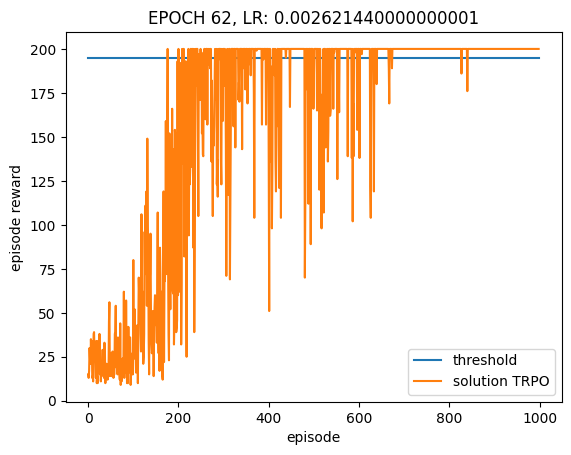

done


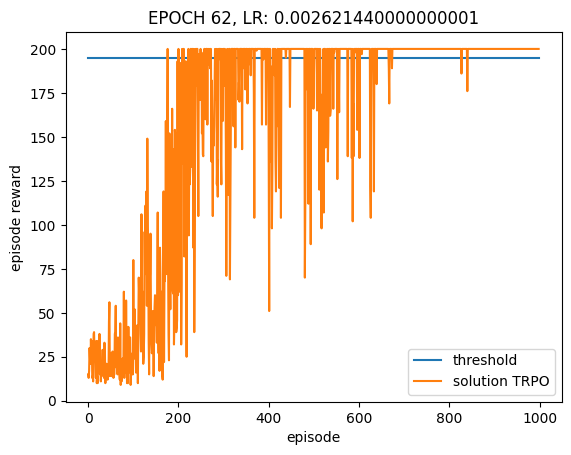

In [ ]:
env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
alpha = 0.01 # learning rate
gamma = 0.8 #scheduler

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 1000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 20
model = TRPO(n_states, n_actions, n_hidden,alpha, gamma)

batch_states = []
batch_actions = []
batch_next_states = []
batch_rewards = []


batch_size = 15

epoch = 0

# TRPO
for i_episode in range(EPISODES_MAX):

    observation = env.reset()
    ep_reward = 0
    state = observation
    states = []
    actions = []
    next_states = []
    rewards = []

    if (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution TRPO")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title(f'EPOCH {epoch}, LR: {model.schedular.get_lr()[0]}')
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        action = model.get_action(state)

        observation, reward, done, info = env.step(action)

        ep_reward += reward
        next_state = observation

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)

        if(done):
            log_steps_number [i_episode] = t+1
            break

        # Update current state
        state = next_state


    batch_states.append(states)
    batch_actions.append(actions)
    batch_next_states.append(next_states)
    batch_rewards.append(rewards)

    if(len(batch_states) > batch_size):
        epoch += 1
        model.update(batch_states,batch_actions, batch_next_states,batch_rewards)
        batch_states = []
        batch_actions = []
        batch_next_states = []
        batch_rewards = []
        model.schedular.step()
print("done")

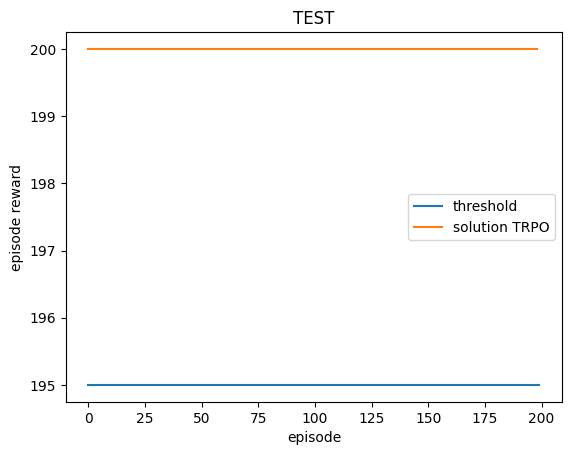

done


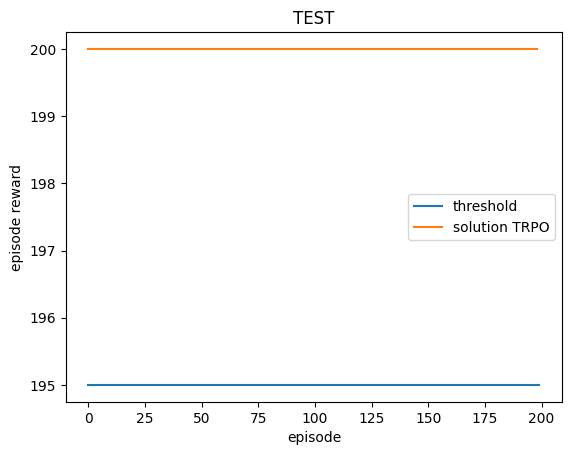

In [ ]:
log_steps_number =np.zeros(200)

for i_episode in range(200):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 10 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_steps_number[0:i_episode], label="solution TRPO")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('TEST')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    for t in range(200):
        action = model.get_action(state)

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        if done:
            log_steps_number[i_episode] = t + 1

            break

        # Update current state
        state = next_state
print("done")